# Irene J. Ventura Farias

### Dataset descargado desde
## https://ieee-dataport.org/documents/smart-defender-dataset

La descripción de los campos que componen los datos del dataset están disponible en esa URL

# PARTE 1: Uso de Spark para análisis de datos, Dataframes #

In [1]:
#Librerías importadas para el notebook
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySparkShell").getOrCreate()

In [2]:
# Mostrar la versión de Spark usada

# Datos de la sesión spark
spark

In [3]:
# Cargar el dataset en un Dataframe
data = spark.read.csv('dataset_descriptor.csv',
                      mode="DROPMALFORMED",
                      inferSchema=True,
                      header=True)

In [4]:
# Mostrar el schema heredado
data.printSchema()

root
 |-- ip_proto: double (nullable = true)
 |-- ip_len_mean: double (nullable = true)
 |-- ip_len_median: double (nullable = true)
 |-- ip_len_var: double (nullable = true)
 |-- ip_len_std: double (nullable = true)
 |-- ip_len_entropy: double (nullable = true)
 |-- ip_len_cv: double (nullable = true)
 |-- ip_len_cvq: double (nullable = true)
 |-- ip_len_rte: double (nullable = true)
 |-- ip_ttl_mean: double (nullable = true)
 |-- ip_ttl_median: double (nullable = true)
 |-- ip_ttl_var: double (nullable = true)
 |-- ip_ttl_std: double (nullable = true)
 |-- ip_ttl_entropy: double (nullable = true)
 |-- ip_ttl_cv: double (nullable = true)
 |-- ip_ttl_cvq: double (nullable = true)
 |-- ip_ttl_rte: double (nullable = true)
 |-- sport_mean: double (nullable = true)
 |-- sport_median: double (nullable = true)
 |-- sport_var: double (nullable = true)
 |-- sport_std: double (nullable = true)
 |-- sport_entropy: double (nullable = true)
 |-- sport_cv: double (nullable = true)
 |-- sport_cvq: 

In [5]:
# Mostrar el número de registros del dataset
data.count()

45500

In [6]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?
Q1 = data.select("Label1").distinct()
Q1.show()

+-----------------+
|           Label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|    tcp_fin_flood|
|  http_slow_range|
|           normal|
|        udp_flood|
|   http_slow_read|
|tcp_syn_ack_flood|
|    tcp_syn_flood|
|    tcp_ack_flood|
|http_slow_headers|
+-----------------+



In [7]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?
Q2 = data.select("Label3").distinct()
Q2.show()

+----------+
|    Label3|
+----------+
|http_flood|
| tcp_flood|
|    normal|
| udp_flood|
| http_slow|
+----------+



In [8]:
#Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.

# Contabilizamos los casos que no son normal 
no_normal = data.filter(data['Label3'] != "normal").count() 
# Contabilizamos todos los casos
total = data.count()
# Calculamos el porcentaje de los anormales sobre el total y redondeamos el total a dos décimales 
Q3 = round((no_normal/total)*100,2)
# Imprimimos el resultado
print(str(Q3)+"%")

49.26%


In [9]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico 
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcent2ajes (bar plot)


#Agrupamos por la etiqueta 'Label3' y contabilizamos por tipo cuantos hay 
Q4 = data.groupBy("Label3").count()

# Renombramos la columna Label3 como traffic, y creamos una nueva columna 
# que calcule el porcentaje de cada tipo de tráfico sobre el total (que calculamos en Q3) 
Q4 = Q4.select( Q4['Label3'].alias("traffic"),((Q4['count']/total)* 100).alias('percentage')).toPandas()

Q4

,traffic,percentage
0,http_flood,0.762637
1,tcp_flood,32.940659
2,normal,50.742857
3,udp_flood,15.151648
4,http_slow,0.402198


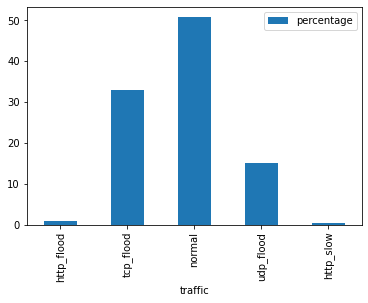

In [10]:
#Importamos la librería para obtener el diagrama de barras 
import matplotlib.pyplot as plt

Q4.plot(kind="bar", x="traffic")
plt.show()

In [11]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir 
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

# Obtenemos el tipo de tráfico multiplicando el campo ip_proto x 1000
data = data.withColumn("ip_proto_int", data["ip_proto"]*1000)
#Nos aseguramos de obtener todos los posibles tipos de protocolo 
Q5 = data.select("ip_proto_int").distinct()
Q5.show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [12]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) 
# de bytes transmitidos agrupados por protocolo

# Del campo que calculamos en Q5 agrupamos y obtenemos la suma total de ip_lean_mean
Q6 = data.groupBy('ip_proto_int').sum('ip_len_mean')
Q6.show()

+------------+------------------+
|ip_proto_int|  sum(ip_len_mean)|
+------------+------------------+
|        17.0| 7064.346040678179|
|         6.0|26867.191474056694|
+------------+------------------+



In [13]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor

# Filtramos por el tráfico UDP (IANA = 17),
# agrupamos por Label 1 y hacemos la suma total del campo ip_lean_mean,
# especificando el orden en que queremos la solucion
Q7 = data.filter(data['ip_proto_int'] == 17.0).groupBy('Label1')\
.sum('ip_len_mean').orderBy('sum(ip_len_mean)', ascending=False)
Q7.show()

+---------+------------------+
|   Label1|  sum(ip_len_mean)|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



In [14]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor

#Mantenemos la misma lógica del Q7 pero filtrando para el caso de TCP (6)
Q8 = data.filter(data['ip_proto_int'] == 6.0).groupBy('Label1')\
.sum('ip_len_mean').orderBy('sum(ip_len_mean)', ascending=False)
Q8.show()

+-----------------+------------------+
|           Label1|  sum(ip_len_mean)|
+-----------------+------------------+
|           normal|11615.053998509022|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_fin_flood|            2000.0|
|    tcp_ack_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



# PARTE 2: Uso de Spark para análisis de datos, Spark SQL #

Contestar a las cuestiones anteriores empleando Spark SQL

In [15]:
# Crear la vista en memoria y añadir una celda por cada cuestión que se debe responder
data.createOrReplaceTempView("TP2View")

In [16]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?
spark.sql("SELECT DISTINCT Label1\
          FROM TP2View ").show()

+-----------------+
|           Label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|    tcp_fin_flood|
|  http_slow_range|
|           normal|
|        udp_flood|
|   http_slow_read|
|tcp_syn_ack_flood|
|    tcp_syn_flood|
|    tcp_ack_flood|
|http_slow_headers|
+-----------------+



In [17]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?
spark.sql("SELECT DISTINCT Label3\
          FROM TP2View").show()

+----------+
|    Label3|
+----------+
|http_flood|
| tcp_flood|
|    normal|
| udp_flood|
| http_slow|
+----------+



In [18]:
#Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.

spark.sql("SELECT CONCAT(ROUND((COUNT(Label3)/45500)*100, 2), ' %') AS percentage\
           FROM TP2View\
        WHERE Label3 != 'normal'").show()


+----------+
|percentage|
+----------+
|   49.26 %|
+----------+



In [19]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico 
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcentajes (bar plot)

Q4 = spark.sql("SELECT Label3 AS traffic, (COUNT(*) / 45500) * 100 AS percentage\
           FROM TP2View\
           GROUP BY Label3").toPandas()
Q4

,traffic,percentage
0,http_flood,0.762637
1,tcp_flood,32.940659
2,normal,50.742857
3,udp_flood,15.151648
4,http_slow,0.402198


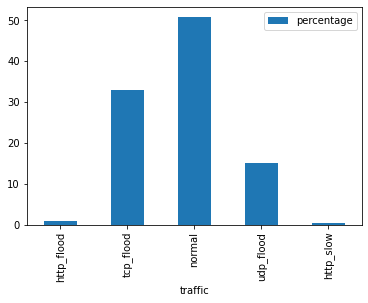

In [20]:
#Importamos la librería para obtener el diagrama de barras 
import matplotlib.pyplot as plt

Q4.plot(kind="bar", x="traffic")
plt.show()

In [21]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir 
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

spark.sql("SELECT DISTINCT (ip_proto*1000) AS ip_proto_int\
           FROM TP2View").show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [22]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) 
# de bytes transmitidos agrupados por protocolo

spark.sql("SELECT ip_proto_int, SUM(ip_len_mean)\
           FROM TP2View GROUP BY ip_proto_int ").show()

+------------+------------------+
|ip_proto_int|  sum(ip_len_mean)|
+------------+------------------+
|        17.0| 7064.346040678179|
|         6.0|26867.191474056694|
+------------+------------------+



In [23]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
spark.sql("SELECT Label1, SUM(ip_len_mean)\
           FROM TP2View\
           WHERE (ip_proto*1000) == 17\
           GROUP BY Label1 ORDER BY sum(ip_len_mean) DESC ").show()

+---------+------------------+
|   Label1|  sum(ip_len_mean)|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



In [24]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor

spark.sql("SELECT Label1, SUM(ip_len_mean)\
           FROM TP2View\
           WHERE (ip_proto*1000) == 6\
           GROUP BY Label1 ORDER BY sum(ip_len_mean) DESC ").show()

+-----------------+------------------+
|           Label1|  sum(ip_len_mean)|
+-----------------+------------------+
|           normal|11615.053998509022|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_fin_flood|            2000.0|
|    tcp_ack_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+

